In [1]:
import pandas as pd
from preprocessing import preprocess

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np

import datetime

import re

In [2]:
class ClaimDataset(Dataset):

  def __init__(self, df):
    # TODO: keep claimid
    self.X = df.drop(columns=["sys_claimid","sys_fraud"]).to_numpy().astype('float32')
    self.y = df["sys_fraud"].to_numpy().astype('int64')
    self.IDs = df["sys_claimid"].to_numpy()
  
  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    tensor = torch.tensor(self.X[index,:])
#     label = torch.LongTensor(self.y[index])
    label = self.y[index]
    ID = self.IDs[index]

    return tensor, label, ID
  
  def number_of_features(self):
    return self.X.shape[1]

In [3]:
class ClaimClassifier(nn.Module):
  def __init__(self, input_neurons):
    super(ClaimClassifier, self).__init__()
    
    #Linear
    self.classifier1 = nn.Linear(input_neurons, 64)
    
    #activation
    self.activation = nn.ReLU()
    
    #Linear
    self.classifier2 = nn.Linear(64, 32)
    
    #Linear
    self.classifier3 = nn.Linear(32, 2)


  def forward(self, tensor):
    
    x = self.classifier1(tensor)
    x = self.activation(x)
    x = self.classifier2(x)
    x = self.activation(x)
    logits = self.classifier3(x)

    return logits

In [4]:
def train_model(model, criterion, optimizer, train_dataloader, test_dataloader, device, epochs, max_patience):
  loss_values = []

  #Training
  print("- - T R A I N I N G - -")

  model_name = "{}.mdl".format(datetime.datetime.now().replace(microsecond=0).isoformat()).replace("/","_")
  patience = 0
  scores = []

  for epoch_i in range(epochs):

    print()
    print('> Epoch {:} of {:}'.format(epoch_i + 1, epochs))

    t0 = time.time()
    total_loss = 0
    
    for step, batch in enumerate(train_dataloader):

      if step % 5000 == 0 and not step == 0:
        print('├───Batch {:>3,} of {:>3,}. time={:.1f}s.'.format(step, len(train_dataloader)-1, time.time() - t0))
      if step == len(train_dataloader)-1:
        print('└───Batch {:>3,} of {:>3,}. time={:.1f}s.'.format(step, len(train_dataloader)-1, time.time() - t0))

      x = batch[0].to(device)
      y = torch.LongTensor(batch[1].to(device))
      #ID = batch[2].to(device)

      model.zero_grad()

      outputs = model(x)
      
      loss = criterion(outputs, y)
      total_loss += loss

      loss.backward()
      
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # TODO:check

      optimizer.step()
    
    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)

    print("")
    print("- Training loss: {0:.2f}".format(avg_train_loss))
    print("- Training Epoch took: {:.1f}s".format(time.time() - t0))
    
    # Validation

    print()
    print("- - V A L I D A T I N G - -")

    t0 = time.time()
    
    total_loss = 0

    model.eval()

    eval_loss, eval_accuracy, eval_auroc, eval_precision, eval_recall = 0, 0, 0, 0, 0
    nb_acc_steps, nb_auroc_steps, nb_eval_examples, nb_prc_steps, nb_rcl_steps = 0, 0, 0, 0, 0

    

    softmax = nn.Softmax(dim=1)
    
    eval_preds = np.array([])
    eval_probs = np.array([])
    eval_labels = np.array([])
    
    
    for batch in test_dataloader:
      x = batch[0].to(device)
      y = torch.LongTensor(batch[1].to(device))
      #ID = batch[2].to(device)

      with torch.no_grad():
        logits = model(x)
      
      loss = criterion(logits, y)

      total_loss += loss.item()
      
      probs = softmax(logits).detach().cpu().numpy()[:,1]
      logits = logits.detach().cpu().numpy()
      labels = y.to('cpu').numpy()
      preds = np.argmax(logits, axis=1).flatten()
      
      eval_preds = np.append(eval_preds, preds)
      eval_probs = np.append(eval_probs, probs)
      eval_labels = np.append(eval_labels, labels)
      
    
    eval_loss = total_loss / len(test_dataloader)
    
    print("")
    print("- Validation Accuracy: {0:.4f}".format(accuracy_score(eval_preds, eval_labels)))
    print("- Validation Precision: {0:.4f}".format(precision_score(eval_preds, eval_labels)))
    print("- Validation Recall: {0:.4f}".format(recall_score(eval_preds, eval_labels)))
    print("- Validation F1: {0:.4f}".format(f1_score(eval_preds, eval_labels)))
    print("- Validation AUROC: {0:.4f}".format(roc_auc_score(eval_labels, eval_probs)))
    print("- Validation loss: {0:.4f}".format(eval_loss))
    print("- Validation took: {:.1f}s".format(time.time() - t0))

    f1 = f1_score(eval_preds, eval_labels)
    # Save if new best score has been achieved
    if len(scores)==0:
      print("")
      print("Saving model...")
      torch.save(model.state_dict(), "savedmodels/{}".format(model_name))
      best_preds = eval_preds
      best_labels = eval_labels
    elif f1 > max(scores):
      print("")
      print("New best F1 score, saving...")
      torch.save(model.state_dict(), "savedmodels/{}".format(model_name))
      best_preds = eval_preds
      best_labels = eval_labels
      patience = 0
    else:
      patience += 1
    
    
    if patience >= max_patience:
      "Maximum patience reached."
      break
    
    scores.append(f1)

    


  print("")
  print("Finished Training")
  print("")
  best_epoch = np.argmax(scores)
  print("Best seen F1 {:.4f} at epoch {}.".format(scores[best_epoch], best_epoch+1))

  print("Best model saved with filename: {}".format(model_name))
  print("Loading best model...")
  best_model = ClaimClassifier(train_dataloader.dataset.number_of_features())
  best_model.load_state_dict(torch.load("savedmodels/{}".format(model_name)))
  best_model.eval()
  print("Done.")

  return best_model, best_preds, best_labels #eval_accuracy/nb_eval_steps, eval_auroc/nb_eval_steps, eval_loss, 


In [21]:
train_file = "data/FRISS_ClaimHistory_training.csv"
test_file = "data/FRISS_ClaimHistory_test.csv"
fraud_file = "data/fraud_cases.csv"

train, test = preprocess(train_file, test_file, fraud_file)

Finished preprocessing.
Dropped 182 Train entries.
Dropped 43 Test entries.
Preprocessing took 1.52 seconds


In [17]:
drop_cols = ['claim_amount_claimed_total', 'occurred_year', 'occurred_month',
            'occurred_day', 'reported_year', 'reported_month', 'reported_day']

train = train.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)

In [18]:
train.columns

Index(['sys_claimid', 'claim_location_urban_area', 'object_year_construction',
       'policy_fleet_flag', 'policy_insured_amount', 'sys_fraud',
       'claim_time_interval', 'cause_Animals', 'cause_Collision',
       'cause_Other', 'cause_Theft', 'cause_Weather', 'make_AUDI', 'make_BMW',
       'make_CITROEN', 'make_OPEL', 'make_OTHER', 'make_RENAULT',
       'make_VOLKSWAGEN', 'profitability_High', 'profitability_Low',
       'profitability_Neutral', 'profitability_Very high',
       'profitability_Very low', 'prev_claims'],
      dtype='object')

In [15]:
# Undersampling

fraud_entries = train[train["sys_fraud"] == 1]
non_fraud_entries = train[train["sys_fraud"] == 0].sample(len(fraud_entries))
train = fraud_entries.append(non_fraud_entries).sample(frac=1.0)

In [22]:
# SMOTE over-sampling

from imblearn.over_sampling import SMOTE
smote = SMOTE()
train, y = smote.fit_resample(train.drop(columns=["sys_fraud"]), train["sys_fraud"])
train["sys_fraud"] = y
train = train.sample(frac=1.0)

In [22]:
# Over and Under sampling

from imblearn.combine import SMOTEENN
smoteenn = SMOTEENN()
train, y = smoteenn.fit_resample(train.drop(columns=["sys_fraud"]), train["sys_fraud"])
train["sys_fraud"] = y
train = train.sample(frac=1.0)

In [23]:
epochs = 60
max_patience = 3

if torch.cuda.is_available():    
  DEVICE = torch.device("cuda")
  print('Using:', torch.cuda.get_device_name(0))
else:
  print('Using: CPU')
  DEVICE = torch.device("cpu")

torch.manual_seed(1)

train_set = ClaimDataset(train)
test_set = ClaimDataset(test)
train_dataloader = DataLoader(train_set, batch_size = 8, num_workers = 2, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size = 1, num_workers = 2, shuffle=False)

input_features = train_set.number_of_features()

model = ClaimClassifier(input_features)
model.to(DEVICE)

weight = torch.tensor([1.0,1.1])

criterion = nn.CrossEntropyLoss(weight = weight)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-6)

model, preds, labels = train_model(model, criterion, optimizer, train_dataloader, test_dataloader, 
                                   DEVICE, epochs, max_patience)

Using: CPU
- - T R A I N I N G - -

> Epoch 1 of 60
├───Batch 5,000 of 19,800. time=9.0s.
├───Batch 10,000 of 19,800. time=22.2s.
├───Batch 15,000 of 19,800. time=35.6s.
└───Batch 19,800 of 19,800. time=49.0s.

- Training loss: 0.69
- Training Epoch took: 49.1s

- - V A L I D A T I N G - -

- Validation Accuracy: 0.1813
- Validation Precision: 0.8824
- Validation Recall: 0.0073
- Validation F1: 0.0145
- Validation AUROC: 0.5707
- Validation loss: 0.7199
- Validation took: 29.6s

Saving model...

> Epoch 2 of 60
├───Batch 5,000 of 19,800. time=16.1s.
├───Batch 10,000 of 19,800. time=28.7s.
├───Batch 15,000 of 19,800. time=43.9s.
└───Batch 19,800 of 19,800. time=57.6s.

- Training loss: 0.66
- Training Epoch took: 57.7s

- - V A L I D A T I N G - -

- Validation Accuracy: 0.7623
- Validation Precision: 0.3676
- Validation Recall: 0.0106
- Validation F1: 0.0206
- Validation AUROC: 0.6078
- Validation loss: 0.6530
- Validation took: 27.7s

New best F1 score, saving...

> Epoch 3 of 60
├───

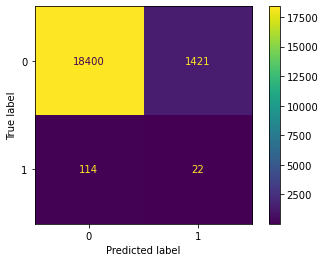

In [24]:
cm = confusion_matrix(labels, preds)

cmd_obj = ConfusionMatrixDisplay(cm) 

cmd_obj.plot()